# One year of LISA data 

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
from gap_study_utils.analysis_data import AnalysisData, get_suggested_tmax
from gap_study_utils.utils.signal_utils import waveform
from gap_study_utils.gaps.gap_funcs import generate_gap_ranges
from gap_study_utils.gaps import GapType
from gap_study_utils.mcmc_runner import run_mcmc
import matplotlib.pyplot as plt

np.random.seed(0)

LN_A = np.log(1e-21)
LN_F = np.log(0.005)
LN_FDOT = np.log(1e-9)

HOURS = 60 * 60
DAYS = 24 * HOURS

np.random.seed(0)
dt = 10
tmax = get_suggested_tmax(DAYS * 365.4)

outdir = f"outdir_1year"
os.makedirs(outdir, exist_ok=True)

gap_ranges = generate_gap_ranges(tmax, gap_period=DAYS * 14, gap_duration=HOURS * 7)
print("Number of gaps: ", len(gap_ranges))


In [ ]:
data = AnalysisData(
    data_kwargs=dict(dt=dt, noise=False, tmax=tmax),
    gap_kwargs=dict(type=GapType.RECTANGULAR_WINDOW, gap_ranges=gap_ranges),
    waveform_generator=waveform,
    waveform_parameters=[LN_A, LN_F, LN_FDOT],
);

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3.3))
fig, _ = data.data_wavelet.plot(ax=ax, whiten_by=None, freq_range=[0.005, 0.028])
fig.savefig(os.path.join(outdir, "data_wavelet.png"), bbox_inches="tight")

![outdir_1year/data_wavelet.png](outdir_1year/data_wavelet.png)

In [4]:
%%timeit

data.lnl(LN_A, LN_F, LN_FDOT)

400 ms ± 20.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## MCMC

[16:02:35] INFO     Initalizing GapWindow with RECTANGULAR_WINDOW gaps (17 gaps).              ]8;id=185047;file:///Users/avaj0001/Documents/projects/pywavelet/case_studies.gaps/src/gap_study_utils/analysis_data.py\analysis_data.py]8;;\:]8;id=144627;file:///Users/avaj0001/Documents/projects/pywavelet/case_studies.gaps/src/gap_study_utils/analysis_data.py#125\125]8;;\

[16:02:36] INFO     AnalysisData initialized.                                                   ]8;id=842902;file:///Users/avaj0001/Documents/projects/pywavelet/case_studies.gaps/src/gap_study_utils/analysis_data.py\analysis_data.py]8;;\:]8;id=319218;file:///Users/avaj0001/Documents/projects/pywavelet/case_studies.gaps/src/gap_study_utils/analysis_data.py#81\81]8;;\

[16:02:37] INFO     ht: TimeSeries(n=2^21, trange=[0.00, 242.73] day, T=242.73 day, fs=0.10 Hz) ]8;id=666065;file:///Users/avaj0001/Documents/projects/pywavelet/case_studies.gaps/src/gap_study_utils/analysis_data.py\analysis_data.py]8;;\:]8;id=794301;file:///Users/avaj0001/Documents/projects/pywavelet/case_studies.gaps/src/gap_study_utils/analysis_data.py#82\82]8;;\
                    gaps: GapWindow(RECTANGULAR_WINDOW, 42,823/2,097,152 NaNs)                                     
                    windowed: False                                                                                
                    noise: False                                                                                   
                    optimal_snr: 544.25                                                                            
                    matched_filter_snr: 544.25                                                                     
                    optimal_wavelet_snr: 504.43                                                                    
                    matched_filter_wavelet_snr: 493.9                                                              
                    optimal_data_wavelet_snr: 494.5                                                                
                    matched_filter_data_wavelet_snr: 494.5                                                         

           INFO     Starting coordinates: , [-48.33850416  -5.29831841 -20.7232853 ]             ]8;id=783736;file:///Users/avaj0001/Documents/projects/pywavelet/case_studies.gaps/src/gap_study_utils/mcmc_runner.py\mcmc_runner.py]8;;\:]8;id=965164;file:///Users/avaj0001/Documents/projects/pywavelet/case_studies.gaps/src/gap_study_utils/mcmc_runner.py#114\114]8;;\

           INFO     true values: [-48.35428695287496, -5.298317366548036, -20.72326583694641]    ]8;id=14649;file:///Users/avaj0001/Documents/projects/pywavelet/case_studies.gaps/src/gap_study_utils/mcmc_runner.py\mcmc_runner.py]8;;\:]8;id=134221;file:///Users/avaj0001/Documents/projects/pywavelet/case_studies.gaps/src/gap_study_utils/mcmc_runner.py#115\115]8;;\

           INFO     Value of likelihood[time-freq] at true values is  1.864e+01                  ]8;id=955859;file:///Users/avaj0001/Documents/projects/pywavelet/case_studies.gaps/src/gap_study_utils/mcmc_runner.py\mcmc_runner.py]8;;\:]8;id=502580;file:///Users/avaj0001/Documents/projects/pywavelet/case_studies.gaps/src/gap_study_utils/mcmc_runner.py#120\120]8;;\

Python(34791) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34792) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34793) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34794) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34795) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34796) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34797) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34798) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34799) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34800) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34801) Malloc

[16:02:38] INFO     Running burnin phase                                                         ]8;id=689535;file:///Users/avaj0001/Documents/projects/pywavelet/case_studies.gaps/src/gap_study_utils/mcmc_runner.py\mcmc_runner.py]8;;\:]8;id=12034;file:///Users/avaj0001/Documents/projects/pywavelet/case_studies.gaps/src/gap_study_utils/mcmc_runner.py#132\132]8;;\

100%|██████████| 150/150 [15:06<00:00,  6.04s/it]


[16:17:50] INFO     Sampling                                                                     ]8;id=103865;file:///Users/avaj0001/Documents/projects/pywavelet/case_studies.gaps/src/gap_study_utils/mcmc_runner.py\mcmc_runner.py]8;;\:]8;id=988249;file:///Users/avaj0001/Documents/projects/pywavelet/case_studies.gaps/src/gap_study_utils/mcmc_runner.py#136\136]8;;\

100%|██████████| 250/250 [29:55<00:00,  7.18s/it]


[16:47:47] INFO     Saved chain to outdir_1year/mcmc_no_noise/emcee_chain.nc                               ]8;id=594337;file:///Users/avaj0001/Documents/projects/pywavelet/case_studies.gaps/src/gap_study_utils/utils/io.py\io.py]8;;\:]8;id=845761;file:///Users/avaj0001/Documents/projects/pywavelet/case_studies.gaps/src/gap_study_utils/utils/io.py#28\28]8;;\

           INFO     Making plots                                                                 ]8;id=33486;file:///Users/avaj0001/Documents/projects/pywavelet/case_studies.gaps/src/gap_study_utils/mcmc_runner.py\mcmc_runner.py]8;;\:]8;id=849948;file:///Users/avaj0001/Documents/projects/pywavelet/case_studies.gaps/src/gap_study_utils/mcmc_runner.py#145\145]8;;\

[16:47:55] INFO     Runtime: 45m11s                                                              ]8;id=627790;file:///Users/avaj0001/Documents/projects/pywavelet/case_studies.gaps/src/gap_study_utils/mcmc_runner.py\mcmc_runner.py]8;;\:]8;id=358530;file:///Users/avaj0001/Documents/projects/pywavelet/case_studies.gaps/src/gap_study_utils/mcmc_runner.py#150\150]8;;\

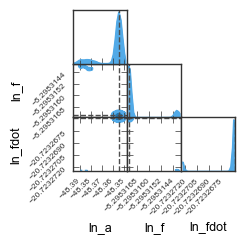

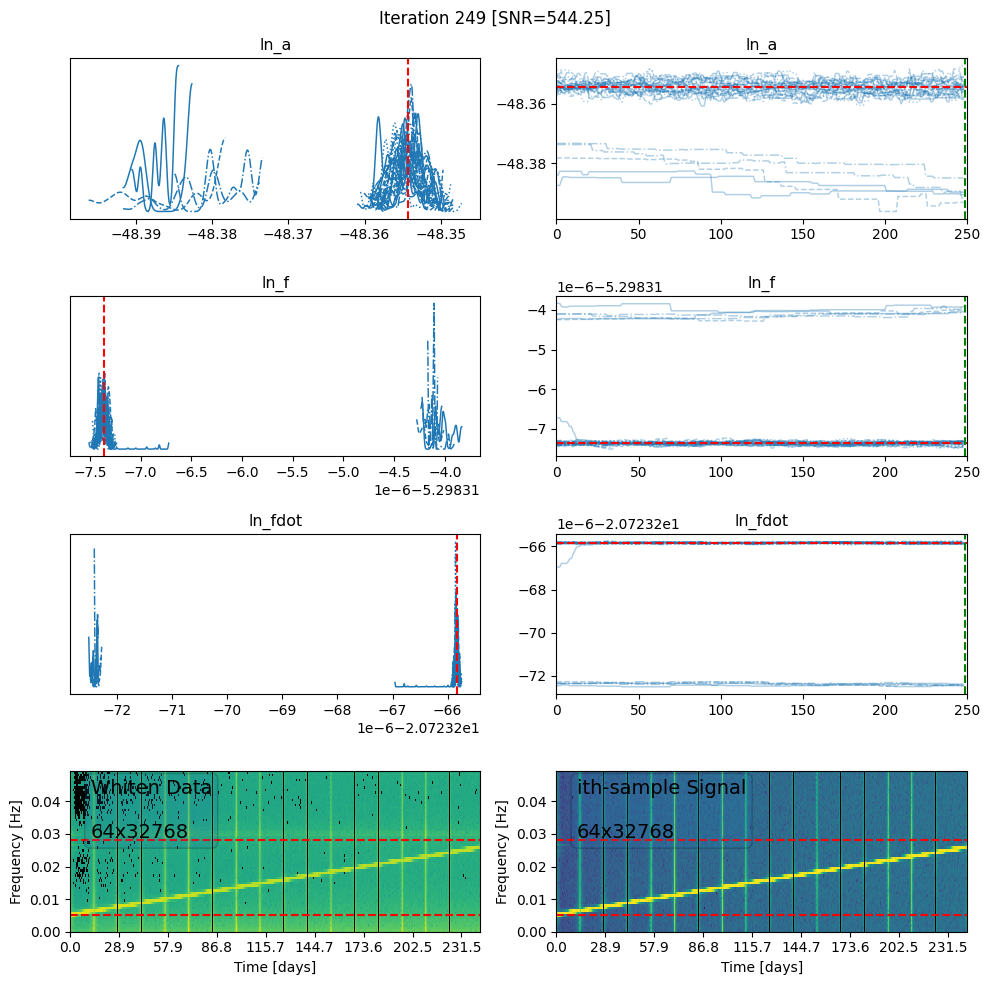

In [24]:
run_mcmc(
    true_params=[LN_A, LN_F, LN_FDOT],
    gap_ranges=gap_ranges,
    gap_type="rectangular_window",
    Nf=64,
    tmax=tmax,
    dt=dt,
    alpha=0.0,
    highpass_fmin=None,
    frange=[0.005, 0.028],
    noise_realisation=False,
    outdir=f"{outdir}/mcmc_no_noise",
    noise_curve='TDI1',
    burnin=150,
    n_iter=250
)

SyntaxError: invalid syntax (741900158.py, line 1)